**Load necessary modules**

In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate as sr
import matplotlib.pyplot as plt
import pandas as pd

**A huge dataset:** In the following few cells we analyze a huge dataset that contains the following experiment. We create a uniform 30x30 grid of (w,b) values and for each we value sample 100 realizations of $W_{\rm in}$ and $b_{\rm in}$ and find the corresponding $W$. In the cell below we figure out which initializations produced good forecasts and which ones did not. In total we have 90000 realizations to analyze which took a loooooong time to upload on Github!

**Find good-bad initializations**

In [26]:
bra = sr.BatchRunAnalyzer_SMLR(save_folder='../data/L63-SMLR-1')
data = bra.get_data()
tau_lims = np.array([3., 5.])
good, bad, all = [], [], []
for idx, row in data.iterrows():
    ijk = [int(row['i']), int(row['j']), int(row['k'])]
    all.append(ijk)
    if row['tau_f_rmse'] < tau_lims[0]:
        bad.append(ijk)
    elif row['tau_f_rmse'] > tau_lims[1]:
        good.append(ijk)

**Read $W_{\rm in}$ for a few models in every category: "good", "bad" and "all"**

In [31]:
L63_data_folder = '../data/L63-trajectories'
# u0 = np.load('{}/validation.npy'.format(L63_data_folder))[:, :1].flatten()
# u0 /= np.linalg.norm(u0)
good_W_in, bad_W_in, all_W_in, s = [], [], [], 100
random_idx = np.random.choice(len(good), size=s, replace=False)
for idx in [good[i] for i in random_idx]:
    good_W_in.append(bra.get_W_in(*idx))
# good_W_in = np.array(good_W_in)
random_idx = np.random.choice(len(bad), size=s, replace=False)
for idx in [bad[i] for i in random_idx]:
    bad_W_in.append(bra.get_W_in(*idx))
# bad_W_in = np.array(bad_W_in)
random_idx = np.random.choice(len(all), size=s, replace=False)
for idx in [all[i] for i in random_idx]:
    all_W_in.append(bra.get_W_in(*idx))

**Create a matrix-flattener for easier plotting**

In [32]:
def flatten(list_of_matrices):
    data = []
    for matrix in list_of_matrices:
        data += list(zip(range(np.prod(matrix.shape)), matrix.flatten()))
    return np.array(data)

**Scatter plot entries of $W_{\rm in}$**

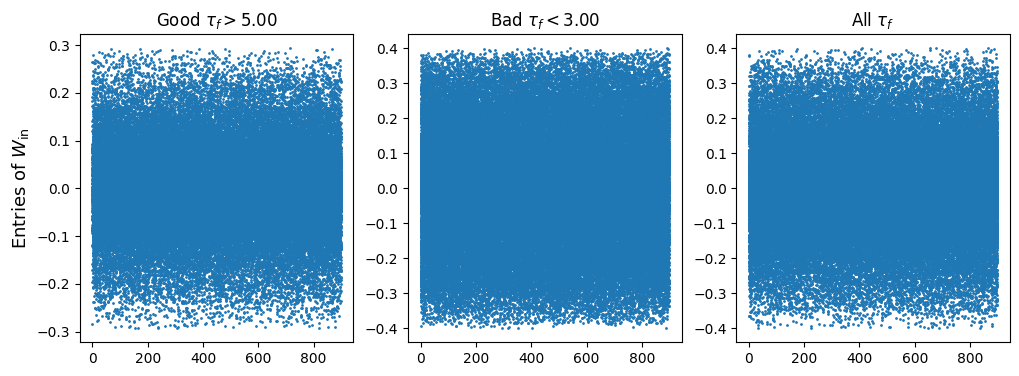

In [33]:
s = 1
fig = plt.figure(figsize=(12, 4))
ax_g = fig.add_subplot(131)
ax_b = fig.add_subplot(132)
ax_a = fig.add_subplot(133)
data_g = flatten(good_W_in)
ax_g.scatter(data_g[:, 0], data_g[:, 1], s=s);
ax_g.set_title(r'Good $\tau_f>{:.2f}$'.format(tau_lims[1]))
ax_g.set_ylabel(r'Entries of $W_{\rm in}$', fontsize=13)
# ax_g.legend()
data_b = flatten(bad_W_in)
ax_b.scatter(data_b[:, 0], data_b[:, 1], s=s);
ax_b.set_title(r'Bad $\tau_f<{:.2f}$'.format(tau_lims[0]));
# ax_b.legend()
data_a = flatten(all_W_in)
ax_a.scatter(data_a[:, 0], data_a[:, 1], s=s);
ax_a.set_title(r'All $\tau_f$');
plt.savefig('../data/L63-SMLR-1/plots/entries_W_in.png')

**Eliminating the band:** As you can clearly see, there is a band near zero where a lot of good entries congregate. Let's eliminate the entries in this band and see how many zero rows there are in $W_{\rm in}$.

Text(0, 0.5, 'zero rows')

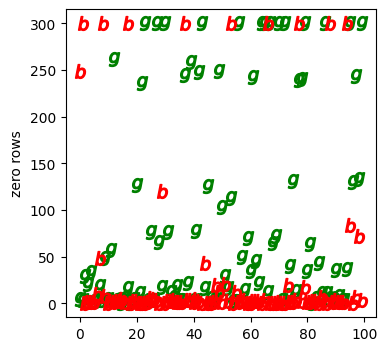

In [35]:
def count_zero_rows(matrix, limits):
    new_matrix = matrix.copy()
    new_matrix[(matrix > limits[0]) & (matrix < limits[1])] = 0. 
    return np.sum(~(new_matrix.any(1)))

def count_zero_rows_for_list_of_matrices(list_of_matrices, limits):
    data = np.zeros((len(list_of_matrices), 2))
    for i, matrix in enumerate(list_of_matrices):
        data[i, :] = [i, count_zero_rows(matrix, limits)] 
    return data
    
s, threshold = 100, [-0.05, 0.05]
fig_1 = plt.figure(figsize=(4, 4))
ax = fig_1.add_subplot(111)
zero_rows_g = count_zero_rows_for_list_of_matrices(good_W_in, threshold)
zero_rows_b = count_zero_rows_for_list_of_matrices(bad_W_in, threshold)
zero_rows_a = count_zero_rows_for_list_of_matrices(all_W_in, threshold)
ax.scatter(zero_rows_g[:, 0], zero_rows_g[:, 1], s=s, c='green', marker=r'$g$')
ax.scatter(zero_rows_b[:, 0], zero_rows_b[:, 1], s=s, c='red', marker=r'$b$')
# ax.scatter(zero_rows_a[:, 0], zero_rows_a[:, 1], s=s, c='darkgrey', marker=r'$a$')
ax.set_ylabel('zero rows')

**A smaller dataset:** In the following few cells we analyze a smaller dataset that contains the following experiment. We pick two values of the pair (w,b) and for each we value sample 1000 realizations of $W_{\rm in}$ and $b_{\rm in}$ and find the corresponding $W$. In the cell below we figure out which initializations produced good forecasts and which ones did not. In total we have 2000 realizations to analyze.

**Find good-bad initializations**

In [37]:
L63_data_folder = '../data/L63-trajectories'
u = np.load('{}/validation.npy'.format(L63_data_folder))
rmse_threshold = np.sqrt(5e-2)

bra_g = sr.BatchRunAnalyzer_SMLR(save_folder='../data/L63-SMLR-single-good')
# bra_g.compute_error(u[:, :500], rmse_threshold)
data = bra_g.get_data()
good = []
for idx, row in data.iterrows():
    ijk = [int(row['i']), int(row['j']), int(row['k'])]
    all.append(ijk)
    if row['tau_f_se'] > tau_lims[1]:
        good.append(ijk)

bra_b = sr.BatchRunAnalyzer_SMLR(save_folder='../data/L63-SMLR-single-bad')
# bra_b.compute_error(u[:, :500], rmse_threshold)
data = bra_g.get_data()
bad = []
for idx, row in data.iterrows():
    ijk = [int(row['i']), int(row['j']), int(row['k'])]
    all.append(ijk)
    if row['tau_f_se'] > tau_lims[1]:
        bad.append(ijk)

Time taken by compute_error is 3.588940143585205 seconds


**Read $W_{\rm in}$ for a few models in every category: "good", "bad" and "all"**

In [23]:
good_W_in, bad_W_in, all_W_in, s = [], [], [], 10
random_idx = np.random.choice(len(good), size=s, replace=False)
for idx in [good[i] for i in random_idx]:
    good_W_in.append(bra_g.get_W_in(*idx))
# good_W_in = np.array(good_W_in)
random_idx = np.random.choice(len(bad), size=s, replace=False)
for idx in [bad[i] for i in random_idx]:
    bad_W_in.append(bra_b.get_W_in(*idx))
# bad_W_in = np.array(bad_W_in)

**Scatter plot entries of $W_{\rm in}$**

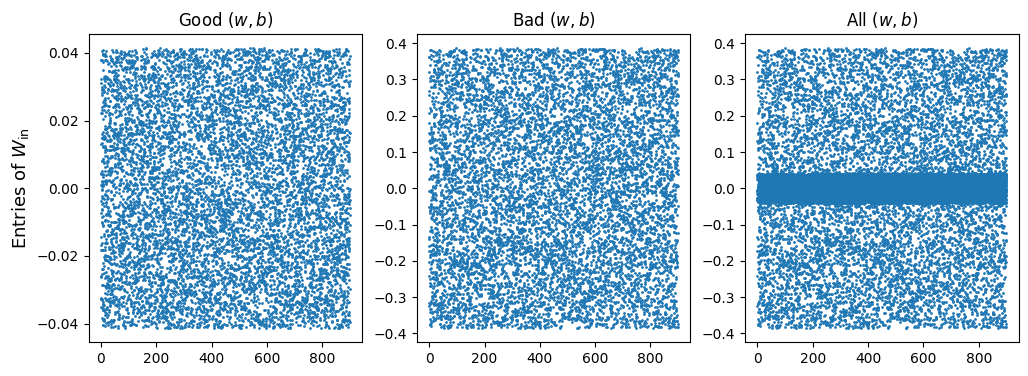

In [24]:
s = 1
fig = plt.figure(figsize=(12, 4))
ax_g = fig.add_subplot(131)
ax_b = fig.add_subplot(132)
ax_a = fig.add_subplot(133)
data_g = flatten(good_W_in)
ax_g.scatter(data_g[:, 0], data_g[:, 1], s=s);
ax_g.set_title(r'Good $(w, b)$')
ax_g.set_ylabel(r'Entries of $W_{\rm in}$', fontsize=13)
# ax_g.legend()
data_b = flatten(bad_W_in)
ax_b.scatter(data_b[:, 0], data_b[:, 1], s=s);
ax_b.set_title(r'Bad $(w, b)$');
# ax_b.legend()
data_a = flatten(good_W_in + bad_W_in)
ax_a.scatter(data_a[:, 0], data_a[:, 1], s=s);
ax_a.set_title(r'All $(w, b)$');
# plt.savefig('../data/L63-SMLR-1/plots/entries_W_in_small.png')

**Useful spare code**

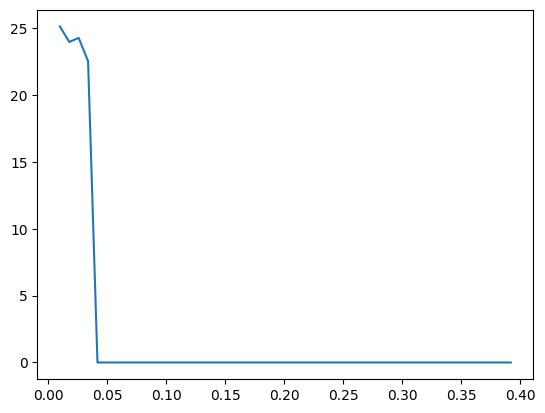

In [25]:
# The following function calculates what fraction of given data lies in a list of growing symmetric intervals
def fractions_in_intervals(data, intervals):
    fractions = np.zeros_like(intervals)
    for i, a in enumerate(intervals):
        fractions[i]  = ((data < a) & (data > -a)).sum() / len(data)
    return fractions

intervals = np.linspace(0.01, 0.4, num=50)
fractions = fractions_in_intervals(data_g[:, 1], intervals)
derivative = np.diff(fractions) / np.diff(intervals)
second_derivative = np.diff(derivative) / np.diff(intervals[:-1])
# plt.plot(intervals[:-1], derivative)
plt.plot(intervals[:-1], np.abs(derivative))